Выбранный датасет содержит 600 000 записей в обучающем наборе и 400 000 в тестовом. Каждая запись содержит id пациента и 13 признаков:

1. Age (возраст);
2. Sex (пол);
3. Resting_blood_pressure (артериальное давление в состоянии покоя);
4. Serum_cholestoral (уровень холестерина в крови mg/dl);
5. Fasting_blood_sugar (анализ глюкозы в крови натощак (> 120 mg/dl));
6. Maximum_heart_rate_achieved (максимальная частота сердечных сокращений);
7. Exercise_induced_angina (стенокардия при нагрузке),
8. Oldpeak (депрессия ST-сегмента);
9. Slope (наклон пикового сегмента ST при физической нагрузке);
10. Number_of_major_vessels (количество крупных сосудов (0-3), окрашенных с помощью флюороскопии);
11. Resting_electrocardiographic_results (результаты электрокардиографических исследований в покое 0, 1, 2);
12. Thal (3 = норма; 6 = фиксированный дефект; 7 = обратимый дефект);
13. Chest_bin (боль в груди от 1 до 4).

- [Ссылка на данные](https://www.kaggle.com/competitions/tech-weekend-data-science-hackathon/data);
- [Ссылка на статью](https://www.sciencedirect.com/science/article/pii/S2772442522000016).

# ПОДГОТОВКА ОКРУЖЕНИЯ

In [1]:
# работа с данными
import pandas as pd
import numpy as np
import joblib

# визуализация данных
import seaborn as sns
import matplotlib.pyplot as plt

# машинное обучение
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# нейронные сети
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# уточнение версий библиотек
print("Версия TF", tf.__version__)
print("Версия Keras", keras.__version__)

We're using TF 2.17.0
We are using Keras 3.5.0


# ПРЕДОБРАБОТКА ДАННЫХ

## чтение данных

In [3]:
df = pd.read_csv('data/train.csv')
df.head()

,ID,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal,class
0,0,49.207124,0,4.000000,162.996167,181.108682,0,0,148.227858,1,0.944547,2,0,3,1
1,1,53.628425,1,1.741596,130.233730,276.474630,0,2,152.917139,0,0.119070,2,0,3,0
2,2,49.591426,1,4.000000,146.999012,223.300517,1,2,102.352090,1,1.616747,2,2,7,1
3,3,58.991445,1,4.000000,112.369143,187.245501,0,0,158.164750,1,0.000000,1,1,7,1
4,4,51.053602,1,1.954609,138.032047,238.482868,0,0,172.540828,0,1.150464,1,1,3,0


In [4]:
# структура датасета
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 15 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   ID                                    600000 non-null  int64  
 1   age                                   600000 non-null  float64
 2   sex                                   600000 non-null  int64  
 3   chest                                 600000 non-null  float64
 4   resting_blood_pressure                600000 non-null  float64
 5   serum_cholestoral                     600000 non-null  float64
 6   fasting_blood_sugar                   600000 non-null  int64  
 7   resting_electrocardiographic_results  600000 non-null  int64  
 8   maximum_heart_rate_achieved           600000 non-null  float64
 9   exercise_induced_angina               600000 non-null  int64  
 10  oldpeak                               600000 non-null  float64
 11  

## фильтрация невалидных значений;

In [5]:
# удаляем столбец c id пациента
df = df.drop('ID',axis=1)

In [6]:
# проверка на дубликаты
df.duplicated().sum()

0

In [7]:
# как найти кол-во пропусков (в процентах)
cols_null_percent = round(df.isnull().mean() * 100, ndigits=2)
cols_with_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)
display(cols_with_null)

Series([], dtype: float64)

In [8]:
## перевод категориальные переменные в тип Object
# задаем вручную список категориальных переменных
cat_list = ([
  'sex',
  # 'chest', # все таки трудно считать его категориальной переменной
  'fasting_blood_sugar',
  'resting_electrocardiographic_results',
  'exercise_induced_angina',
  'slope',
  'number_of_major_vessels',
  'thal'
  ])

# циклом переводим в тип object
for elem in cat_list:
  df[elem] = df[elem].astype(object)

In [9]:
# выделяем отдельно столбцы с количественными переменными
num_cols = df.select_dtypes(include=['number']).columns

## преобразование категориальные переменные в фиктивные переменные.

In [10]:
# перевод категориальных переменных в дамми-переменные
df_mod = pd.get_dummies(
    df,
    columns=cat_list,
    dtype='int',
    drop_first=True
)

# АНАЛИЗ ДАННЫХ

характеристика переменных

In [11]:
df[num_cols].describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
age,600000.0,54.43,9.09,26.06,48.08,55.13,60.66,79.59
chest,600000.0,3.17,0.95,-0.54,3.00,3.00,4.00,4.00
resting_blood_pressure,600000.0,131.34,17.84,82.92,119.92,129.73,139.92,209.67
serum_cholestoral,600000.0,249.59,51.70,98.33,216.48,244.23,274.35,527.76
maximum_heart_rate_achieved,600000.0,149.59,23.07,61.84,135.70,153.22,165.17,208.74
oldpeak,600000.0,1.05,1.14,-0.81,0.00,0.81,1.67,6.80
class,600000.0,0.44,0.50,0.00,0.00,0.00,1.00,1.00


In [12]:
df.select_dtypes(include=['object','category']).describe().transpose()

,count,unique,top,freq
sex,600000,2,1,406468
fasting_blood_sugar,600000,2,0,509546
resting_electrocardiographic_results,600000,3,2,302698
exercise_induced_angina,600000,2,0,399899
slope,600000,3,1,289149
number_of_major_vessels,600000,4,0,353137
thal,600000,3,3,334624


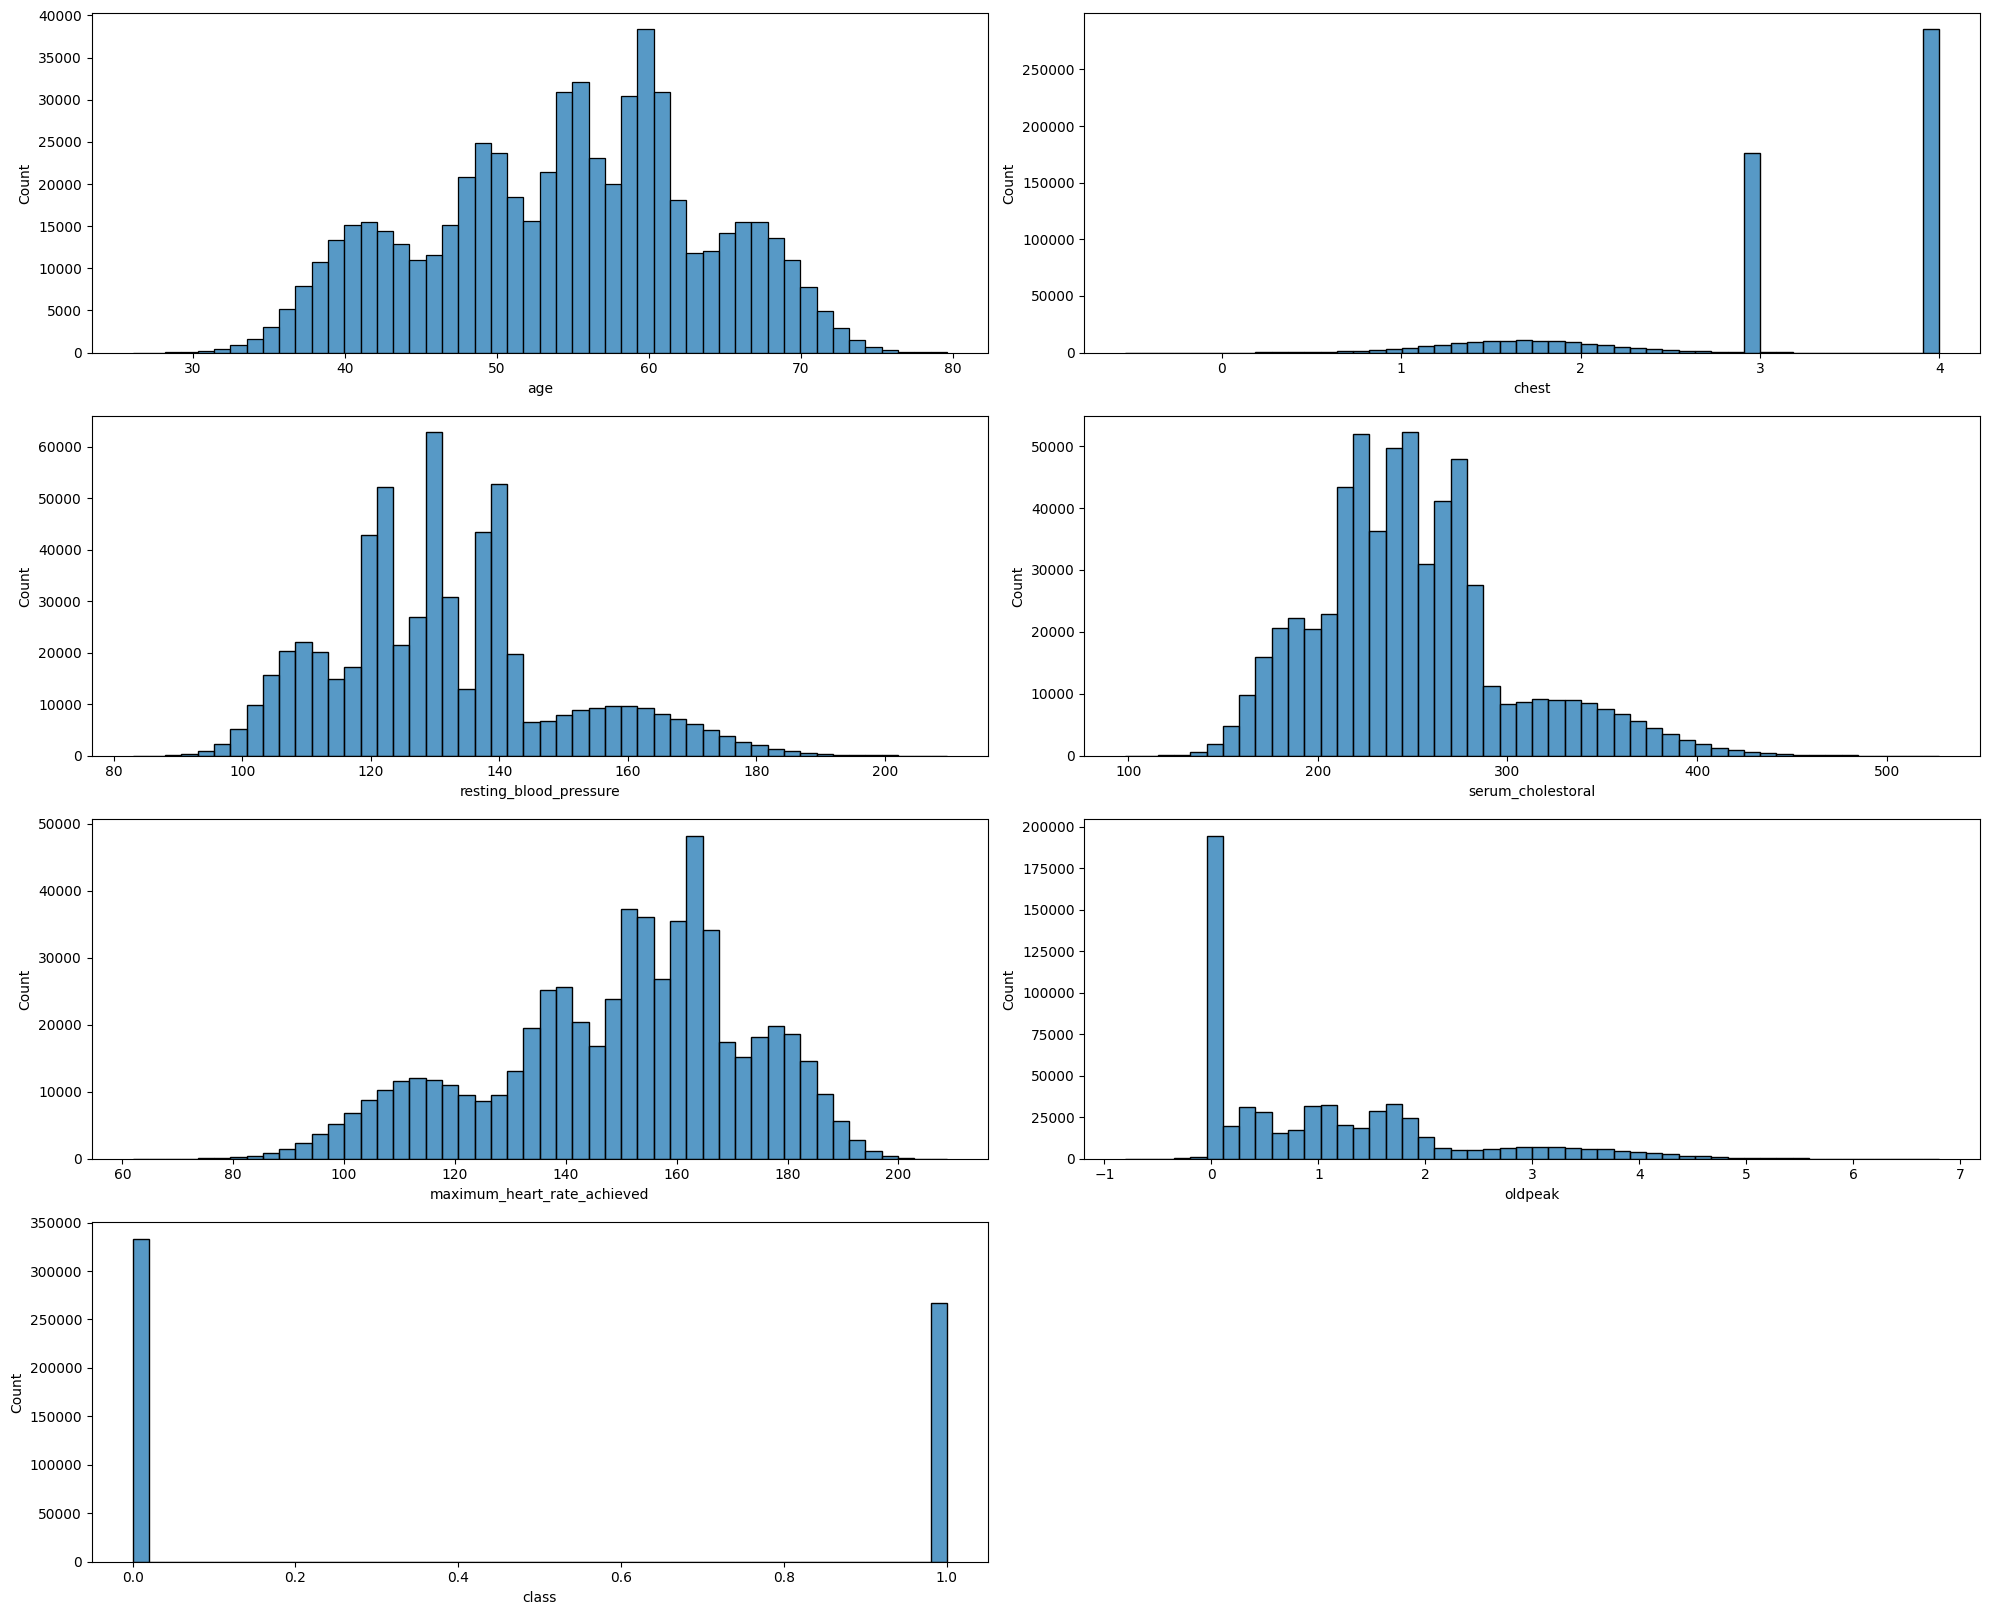

In [13]:
# гистограммы для численных переменных
plt.figure(figsize=(20, 40), dpi=100)

for i, column in enumerate(df[num_cols], start=1):
    plt.subplot(10, 2, i)
    sns.histplot(data=df, x=column, bins=50)
    plt.tight_layout()

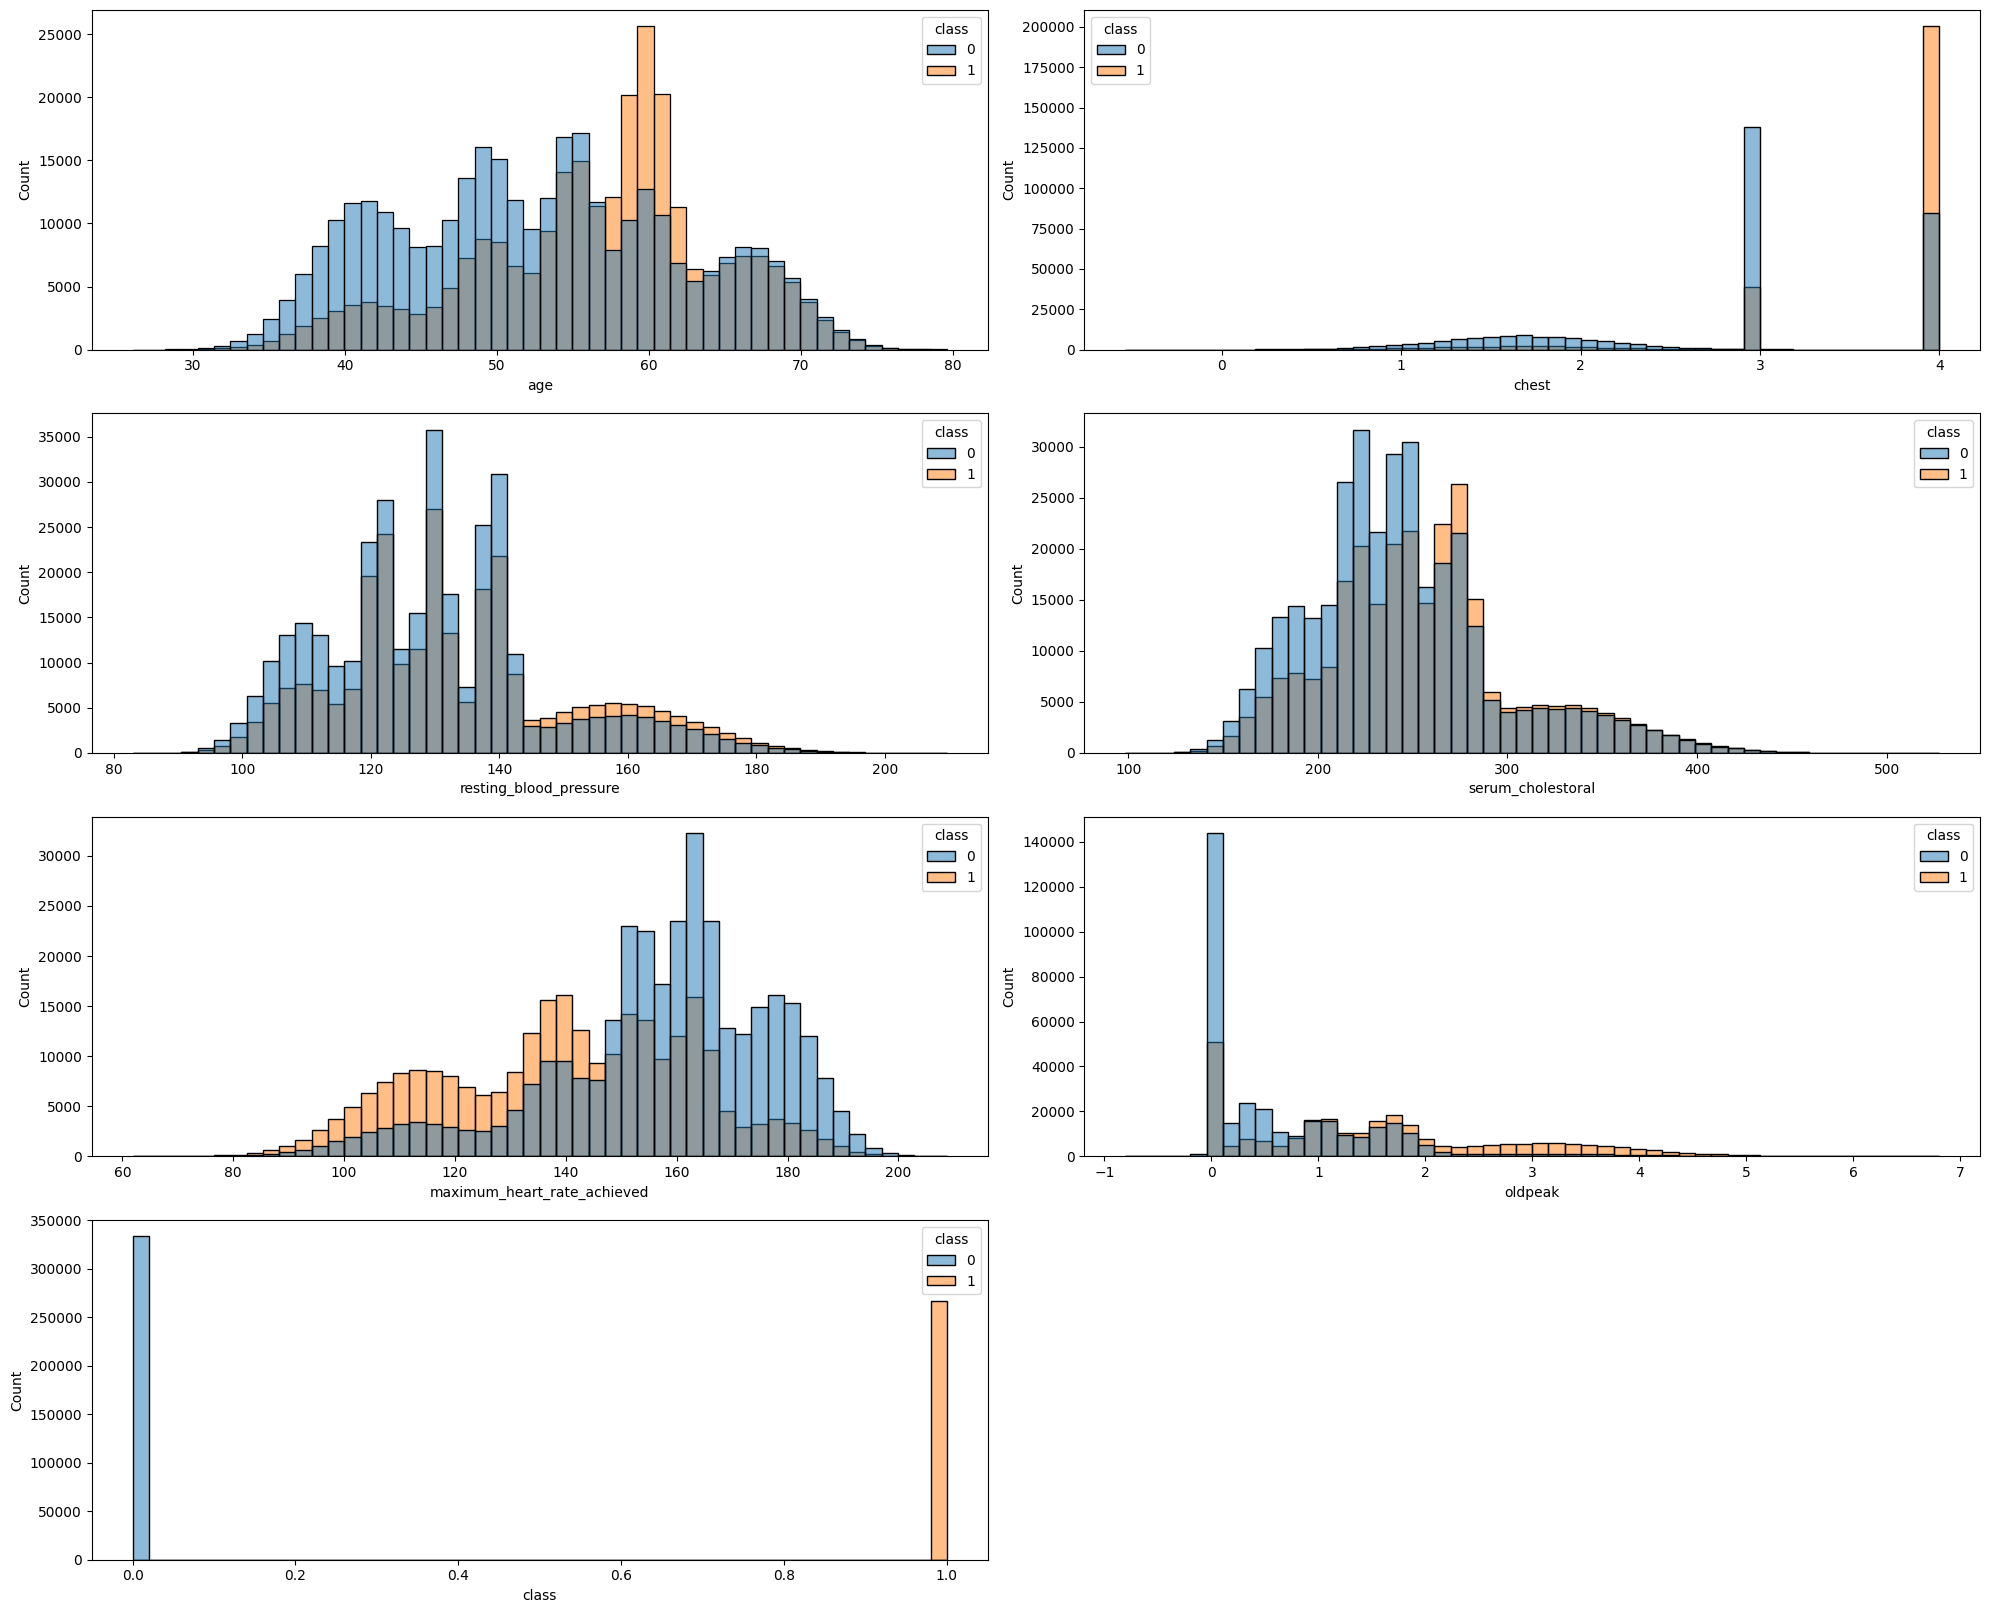

In [14]:
plt.figure(figsize=(20, 40), dpi=100)

for i, column in enumerate(df[num_cols], start=1):
    plt.subplot(10, 2, i)
    sns.histplot(data=df, x=column, hue='class', bins=50)
    plt.tight_layout()

In [15]:
# Check all unique values in categorical columns
for i in cat_list:
    if i in df.columns:
        print('All values in column {0} : \n{1}'.format(i, df[i].value_counts().sort_index()))
        print('\n')
    else:
        print(f'Column {i} not found in the DataFrame.')

# Print the list of categorical columns
print('Categorical columns:', cat_list)

All values in column sex : 
sex
0    193532
1    406468
Name: count, dtype: int64


All values in column fasting_blood_sugar : 
fasting_blood_sugar
0    509546
1     90454
Name: count, dtype: int64


All values in column resting_electrocardiographic_results : 
resting_electrocardiographic_results
0    290609
1      6693
2    302698
Name: count, dtype: int64


All values in column exercise_induced_angina : 
exercise_induced_angina
0    399899
1    200101
Name: count, dtype: int64


All values in column slope : 
slope
1    289149
2    264082
3     46769
Name: count, dtype: int64


All values in column number_of_major_vessels : 
number_of_major_vessels
0    353137
1    129017
2     73773
3     44073
Name: count, dtype: int64


All values in column thal : 
thal
3    334624
6     34677
7    230699
Name: count, dtype: int64


Categorical columns: ['sex', 'fasting_blood_sugar', 'resting_electrocardiographic_results', 'exercise_induced_angina', 'slope', 'number_of_major_vessels', 'thal']


## наличие корреляционного анализа (диаграмма рассеяния, Heatmap корреляционной матрицы);

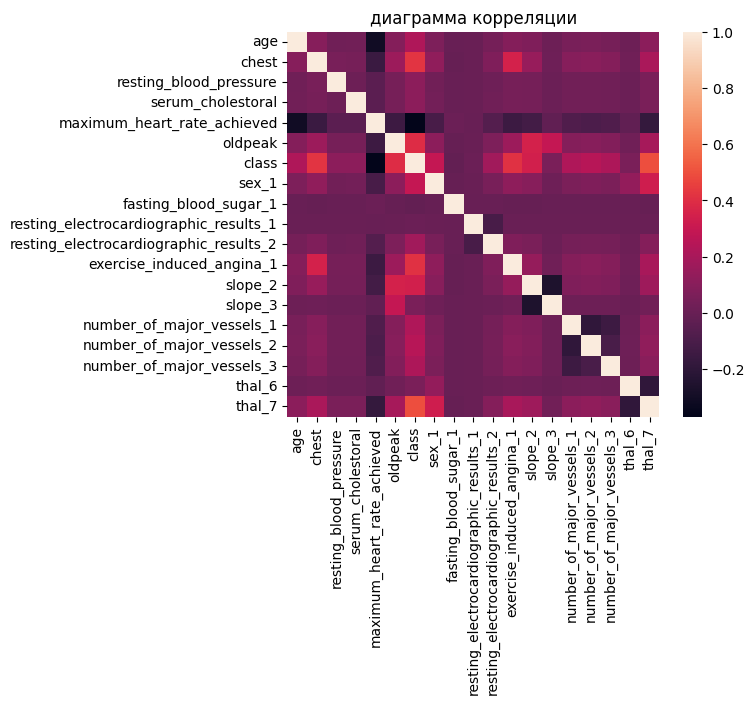

In [16]:
# построение диаграммы корреляции для числовых переменных
plt.figure(figsize=(6, 5), dpi=100)
plt.title("диаграмма корреляции")
sns.heatmap(df_mod.corr(), annot=False, fmt = '0.1f');

## Оценка выбросов («ящик с усами»).

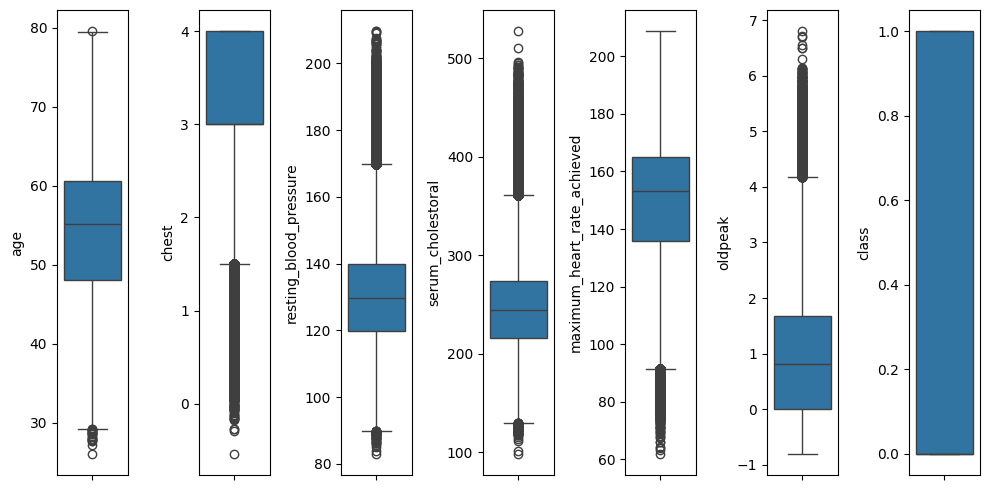

In [17]:
plt.figure(figsize=(10,5))

for i in range(0,len(num_cols)):
    plt.subplot(1,len(num_cols),i+1)
    sns.boxplot(y=df[num_cols[i]])
    plt.tight_layout()

In [18]:
# определяем функцию для работы с выбросами
def treat_outliers(data, factor=1.5):
  q1=np.percentile(data, 25)
  q3=np.percentile(data, 75)
  iqr=q3-q1
  lower_bound=q1-(iqr*factor)
  upper_bound=q3+(iqr*factor)

  treated_data=data.copy()
  treated_data[(data< lower_bound)|(data>upper_bound)] = np.nan

  return treated_data

# проверка количества значений за за пределами iqr
treat_outliers(df[num_cols]).isnull().sum()

age                                0
chest                              0
resting_blood_pressure             0
serum_cholestoral              19202
maximum_heart_rate_achieved        0
oldpeak                            0
class                              0
dtype: int64

с учетом того, что данные переменные могут нести информацию и не является выбросами принято решение их не удалять

# ОБУЧЕНИЕ МОДЕЛЕЙ

## обучение и сравнение моделей

In [19]:
# определение функции для обучения модели и получения метрик
def models_test(X_train, X_test, y_train, y_test, model):

  # обучаем модель
  model.fit(X_train, y_train)

  # получаем результат
  y_pred = model.predict(X_test)
  y_pred_proba = model.predict_proba(X_test)[:, 1]

  # метрики по модели
  conf_matrix = confusion_matrix(y_test, y_pred)
  metrics = {
      'Accuracy': accuracy_score(y_test, y_pred),
      'Precision': precision_score(y_test, y_pred),
      'Recall': recall_score(y_test, y_pred),
      'F1 Score': f1_score(y_test, y_pred),
      'AUC': roc_auc_score(y_test, y_pred_proba),
  }

  return metrics, conf_matrix

In [20]:
# определение используемых функции и параметров
models_dict = {
  'Logistic Regression': LogisticRegression(random_state=42),
  'Дерево решений': DecisionTreeClassifier(random_state=42),
  'Random Forest Classifier': RandomForestClassifier(random_state=42, class_weight='balanced'),
  'XGB Classifier': XGBClassifier(random_state=42)
}

In [21]:
# функция для визуального отражения полученных метрик
def model_perf_vis(dict):
    # пустой словарь
    model_performance = {}

    # получение значений
    for model_name, metrics in dict.items():
        model_performance[model_name] = {
            'Accuracy': metrics['Accuracy'],
            'Precision': metrics['Precision'],
            'Recall': metrics['Recall'],
            'F1 Score': metrics['F1 Score'],
            'AUC': metrics['AUC']
        }

    # извлечь метрики и названия модели
    models = list(model_performance.keys())
    metrics = list(model_performance[models[0]].keys())

    # полотно
    fig, ax = plt.subplots(figsize=(10, 6))

    # отразить каждую метрику отдельной линией
    for metric_name in metrics:
        values = [model_performance[model_name][metric_name] for model_name in models]
        ax.plot(models, values, marker='o', label=metric_name)

    # название и легенда
    ax.set_xlabel('Модель')
    ax.set_ylabel('Метрики')
    ax.set_title('Производительность модели')
    ax.legend()

    # повернуть значения на оси x на 45 градусов
    plt.xticks(rotation=45)

    # показать график
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [22]:
# подготовка данных

# определение целевой переменной
target = 'class'

# разбивка датасета    
X = df_mod.drop(target, axis=1)
y = df_mod[target]

# разделение данных на тренировочный и тестовый сет
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state = 42, stratify=y)

# масштабирование фич
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
# пустые словари для записи в них результатов
metrics_dict = {}
conf_mat_dict = {}

# создание моделей
for name in models_dict:
  metrics_dict[name], conf_mat_dict[name] = models_test(X_train_scaled, X_test_scaled, y_train, y_test, models_dict[name])

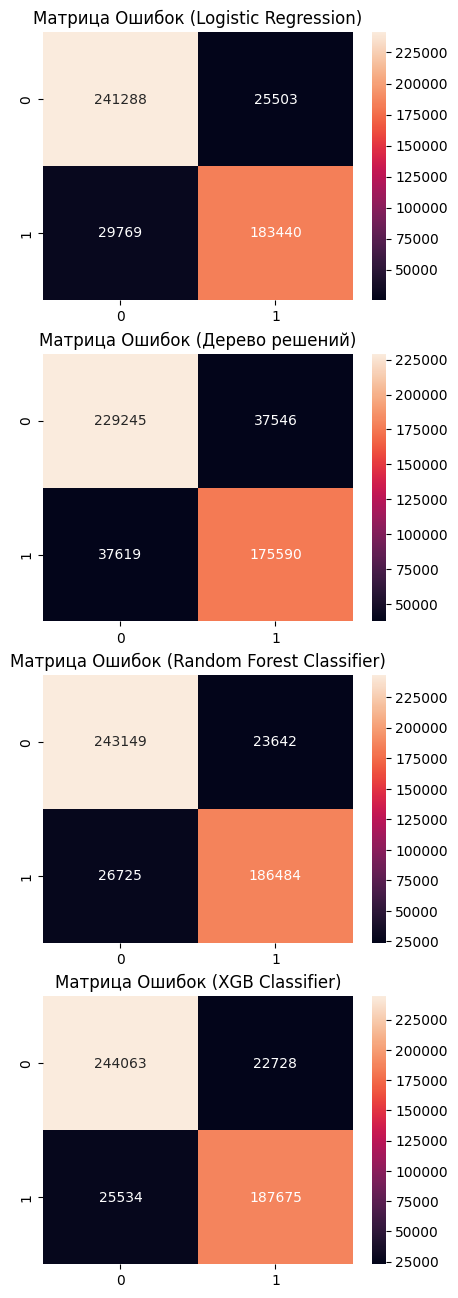

In [24]:
# отрисовка confusion matrixes
n = len(conf_mat_dict)

fig, axes = plt.subplots(n, 1, figsize=(5, n*4))

for index, name in enumerate(conf_mat_dict):
  sns.heatmap(conf_mat_dict[name], annot=True, fmt="d", ax=axes[index])
  axes[index].set_title(f'Матрица Ошибок ({name})')


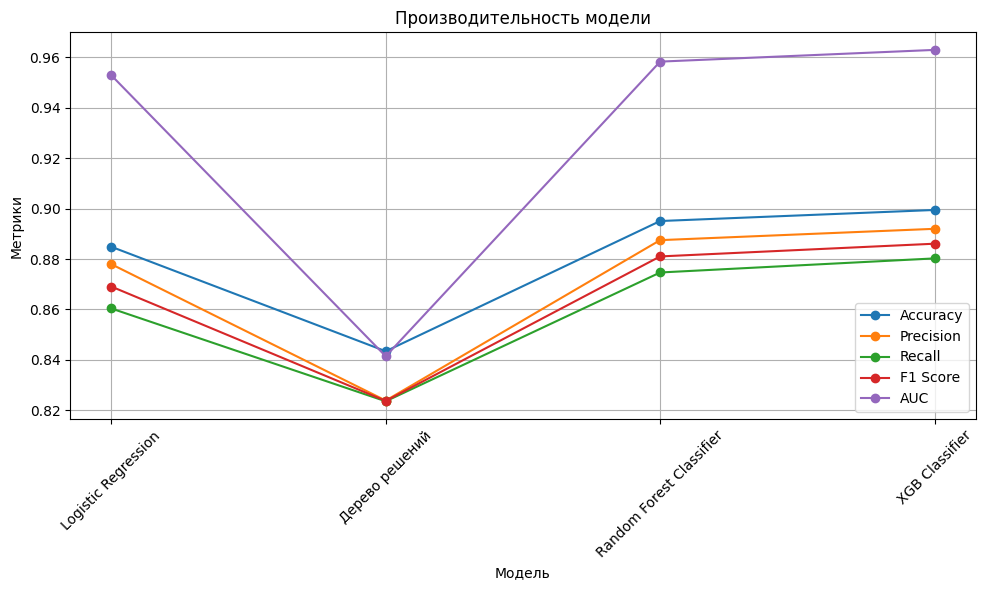

In [25]:
# визуализация метрик
model_perf_vis(metrics_dict)

## Глубокие нейронные сети

In [26]:
X_train_scaled.shape

(120000, 18)

In [27]:
# очистка сессии
clear_session()

In [28]:
# создание сети
model = Sequential()
model.add(Dense(128, activation="relu", input_shape=(X_train_scaled.shape[1],))) # первый скрытый слой
model.add(Dense(128, activation="relu")) 
model.add(Dense(64, activation="relu")) 
model.add(Dense(1, activation="sigmoid"))

/Users/madeliri/Documents/code/ds med/ds_med/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,265 (106.50 KB)

 Trainable params: 27,265 (106.50 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Компиляция модели
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC()]
)

# Обучение модели с ранней остановкой
early_stop = EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=1024,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Оценка модели
y_proba_nn = model.predict(X_test_scaled).ravel()
y_pred_nn = (y_proba_nn > 0.5).astype(int)

print("Глубокая нейронная сеть:")
print(classification_report(y_test, y_pred_nn))
print(f"AUC: {roc_auc_score(y_test, y_proba_nn):.4f}")

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - auc: 0.8724 - loss: 0.4687 - val_auc: 0.9528 - val_loss: 0.2781
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - auc: 0.9522 - loss: 0.2767 - val_auc: 0.9543 - val_loss: 0.2716
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - auc: 0.9556 - loss: 0.2671 - val_auc: 0.9553 - val_loss: 0.2680
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - auc: 0.9557 - loss: 0.2667 - val_auc: 0.9564 - val_loss: 0.2647
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - auc: 0.9568 - loss: 0.2636 - val_auc: 0.9577 - val_loss: 0.2611
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.9581 - loss: 0.2594 - val_auc: 0.9580 - val_loss: 0.2700
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - auc: 0.9584 - loss: 0.2585 - val_auc: 0.9587 - val_loss: 0.2639
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.9594 - loss: 0.2557 - val_auc: 0.9589 - val_loss: 0.2576
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - au

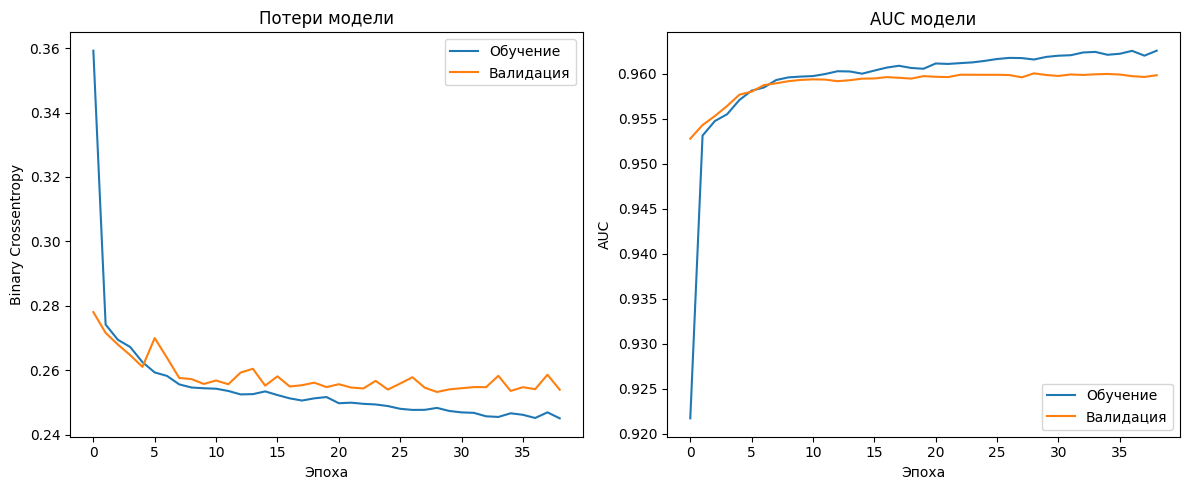

In [31]:
# Графики обучения
plt.figure(figsize=(12, 5))

# Потери
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Обучение')
plt.plot(history.history['val_loss'], label='Валидация')
plt.title('Потери модели')
plt.xlabel('Эпоха')
plt.ylabel('Binary Crossentropy')
plt.legend()

# AUC
plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Обучение')
plt.plot(history.history['val_auc'], label='Валидация')
plt.title('AUC модели')
plt.xlabel('Эпоха')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
metrics_dict['Нейронная сеть'] = {
    'Accuracy': accuracy_score(y_test, y_pred_nn),
    'Precision': precision_score(y_test, y_pred_nn, average='weighted'),
    'Recall': recall_score(y_test, y_pred_nn, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred_nn, average='weighted'),
    'AUC': roc_auc_score(y_test, y_proba_nn)
    }

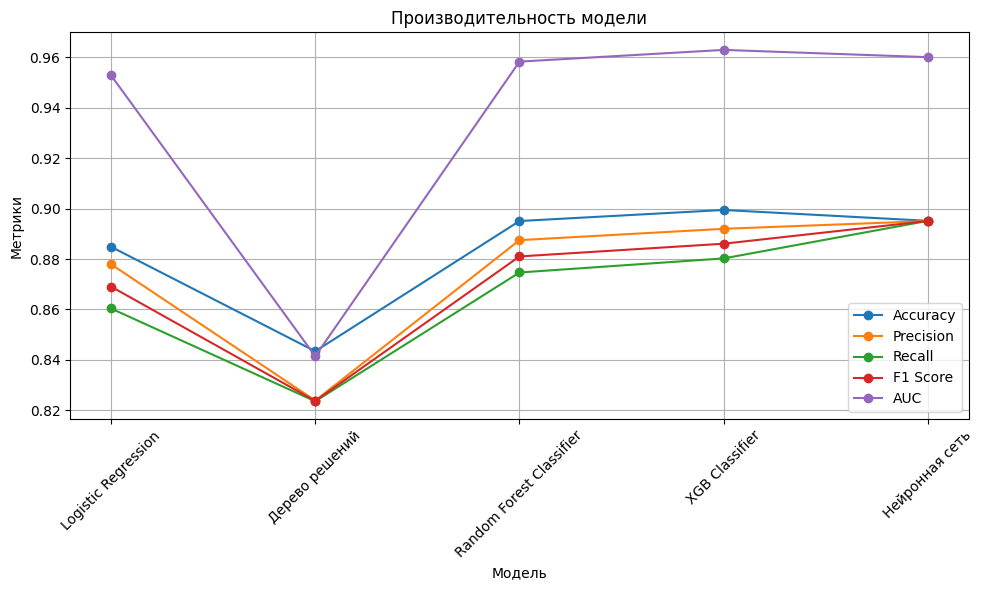

In [33]:
model_perf_vis(metrics_dict)

# ЭКСПОРТ МОДЕЛИ

In [39]:
# используем XGB Classifier как лучшую модель
best_model = models_dict['XGB Classifier']

In [40]:
# экспорт модели и скейлера 
joblib.dump(scaler, 'models/scaler.joblib')
joblib.dump(best_model, 'models/model.joblib')


['models/model.joblib']